In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Data loading

In [112]:
df1_test = pd.read_csv('credit_call_oot.csv')
df1_train = pd.read_csv('credit_call_train.csv')
df2_test = pd.read_csv('credit_card_call_oot.csv')
df2_train = pd.read_csv('credit_card_call_train.csv')
df3_test = pd.read_csv('credit_card_sms_oot.csv')
df3_train = pd.read_csv('credit_card_sms_train.csv')
df4_test = pd.read_csv('credit_sms_oot.csv')
df4_train = pd.read_csv('credit_sms_train.csv')

### Training ML model - Logistic regression and Gradient boosting

In [113]:
def train_model_logistic_regression(df):
    X = df.drop('target', axis=1) 
    y = df['target'] 
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('log_reg', LogisticRegression()) 
    ])
    model_pipeline.fit(X, y)
    return model_pipeline

In [114]:
lr_model1 = train_model_logistic_regression(df1_train)
lr_model2 = train_model_logistic_regression(df2_train)
lr_model3 = train_model_logistic_regression(df3_train)
lr_model4 = train_model_logistic_regression(df4_train)

In [115]:
# def train_model_gradient_boosting(df):
#     X = df.drop('target', axis=1)
#     y = df['target']
#     gradient_model = GradientBoostingClassifier()
#     gradient_model.fit(X, y)
#     return gradient_model

In [116]:
# gb_model1 = train_model_gradient_boosting(df1_train)
# gb_model2 = train_model_gradient_boosting(df2_train)
# gb_model3 = train_model_gradient_boosting(df3_train)
# gb_model4 = train_model_gradient_boosting(df4_train)

### Calculating predicted probabilities

In [117]:
def predict_data(df_test,model):

    X_test = df_test.drop(['target'], axis=1) 
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    return y_pred_prob

In [118]:
y1_ = df1_test['target']
y1_train = df1_train['target']
y1_lr = predict_data(df1_test, lr_model1)
y1_train_pred = predict_data(df1_train, lr_model1)
y2_ = df2_test['target']
y2_train = df2_train['target']
y2_lr = predict_data(df2_test, lr_model2)
y2_train_pred = predict_data(df2_train, lr_model2)
y3_ = df3_test['target']
y3_train = df3_train['target']
y3_lr = predict_data(df3_test, lr_model3)
y3_train_pred = predict_data(df3_train, lr_model3)
y4_ = df4_test['target']
y4_train = df4_train['target']
y4_lr = predict_data(df4_test, lr_model4)
y4_train_pred = predict_data(df4_train, lr_model4)

### Creating bucket plot

In [119]:
def plot_bucket(y_test, y_pred,sample):
    predictions_df = pd.DataFrame({'true_values': y_test, 'predicted_prob': y_pred})
    predictions_df['decile'] = pd.qcut(predictions_df['predicted_prob'], 10, labels=np.arange(1, 11))
    
    bucketed_data = predictions_df.groupby('decile').agg(
        actual=('true_values', 'mean'),
        predicted=('predicted_prob', 'mean')
    ).reset_index()
    
    melted_bucketed_data = bucketed_data.melt(id_vars='decile', value_vars=['actual', 'predicted'])
    
    plt.figure(figsize=(12, 7))
    sns_plot = sns.barplot(data=melted_bucketed_data, x='decile', y='value', hue='variable',
                           palette=sns.color_palette("Paired"), edgecolor='0.2')
    
    plt.title('Распределение прогнозной вероятности и фактического отклика \nна отложенной выборке', fontsize=16)
    plt.xlabel('Номер бакета по скору модели', fontsize=14)
    plt.ylabel('Вероятность, %', fontsize=14)
    sns.set(style="ticks")
    sns_plot.set_xticks(range(0, 10))  
    sns_plot.set_xticklabels([f"{i}" for i in range(1,11)])  
    sns_plot.tick_params(axis='both', which='major', labelsize=12)  
    
    legend_labels, _= sns_plot.get_legend_handles_labels()
    sns_plot.legend(legend_labels, ['Средний фактический отклик', 'Средняя прогнозная вероятность'], fontsize=12, title_fontsize='13', loc='upper left')
    plt.grid()
    plt.tight_layout()
    sns.despine(left=True, bottom=True)  
    plt.savefig(f'{sample}.png')


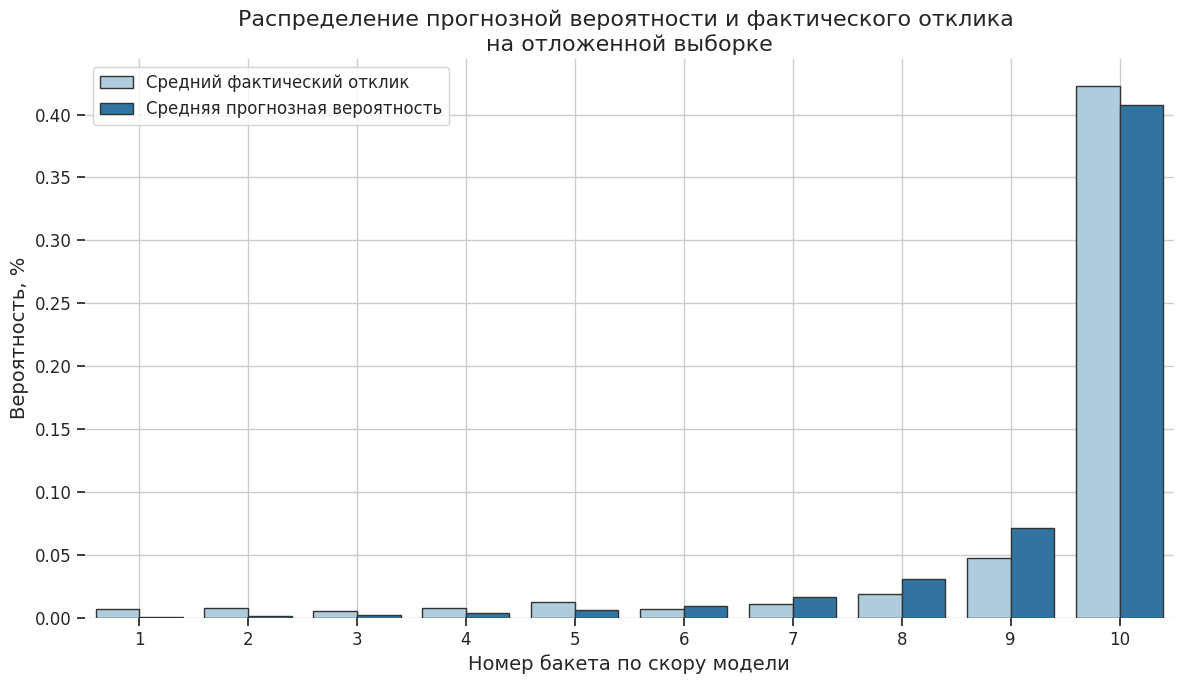

In [120]:
plot_bucket(y1_,y1_lr,'calibration1')

### AUC ROC

In [121]:
def AUC_ROC(y_train, y_pred_train, y_test, y_pred_test, sample):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(10, 8))
    lw = 2  
    
    plt.plot(fpr_train, tpr_train, color='red',
             lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    

    plt.plot(fpr_test, tpr_test, color='blue',
             lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc_test)

    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(f'{sample}.png')
    plt.show()

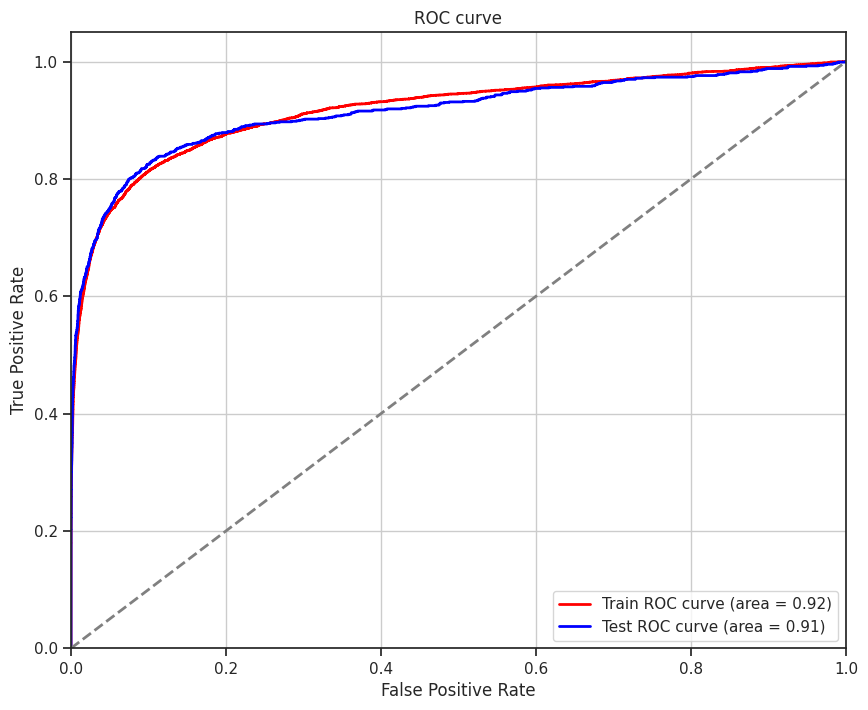

In [122]:
AUC_ROC(y1_train,y1_train_pred,y1_,y1_lr,'AUC_ROC1')

### Lift curve

In [123]:
def plot_lift_curve_percentage(y_train, y_pred_train, y_test, y_pred_test,sample):
    plt.figure(figsize=(12, 7))
    def calculate_lift(y, y_pred):
        data = pd.DataFrame({'true_values': y, 'predicted_prob': y_pred})
        data['rank'] = data['predicted_prob'].rank(pct=True)  
        data.sort_values(by='rank', inplace=True)
        data['cumulative_n'] = np.arange(1, len(data) + 1)
        data['cumulative_true'] = data['true_values'].cumsum()
        total_true = data['true_values'].sum()
        data['lift'] = (data['cumulative_true'] / data['cumulative_n']) / (total_true / len(data)) 
        return data['rank'], data['lift'] 
    
    rank_train, lift_train = calculate_lift(y_train, y_pred_train)
    rank_test, lift_test = calculate_lift(y_test, y_pred_test)
    
    plt.plot(rank_train * 100, lift_train, label='Train Lift', color='blue')
    plt.plot(rank_test * 100, lift_test, label='Test Lift', color='red')
    
    plt.title('Lift Curve: Training vs. Test Data', fontsize=16)
    plt.xlabel('% Customers', fontsize=14)
    plt.ylabel('Lift', fontsize=14)
    plt.xticks(np.linspace(0, 100, 11))  
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    plt.savefig(f'{sample}.png')
    plt.show()

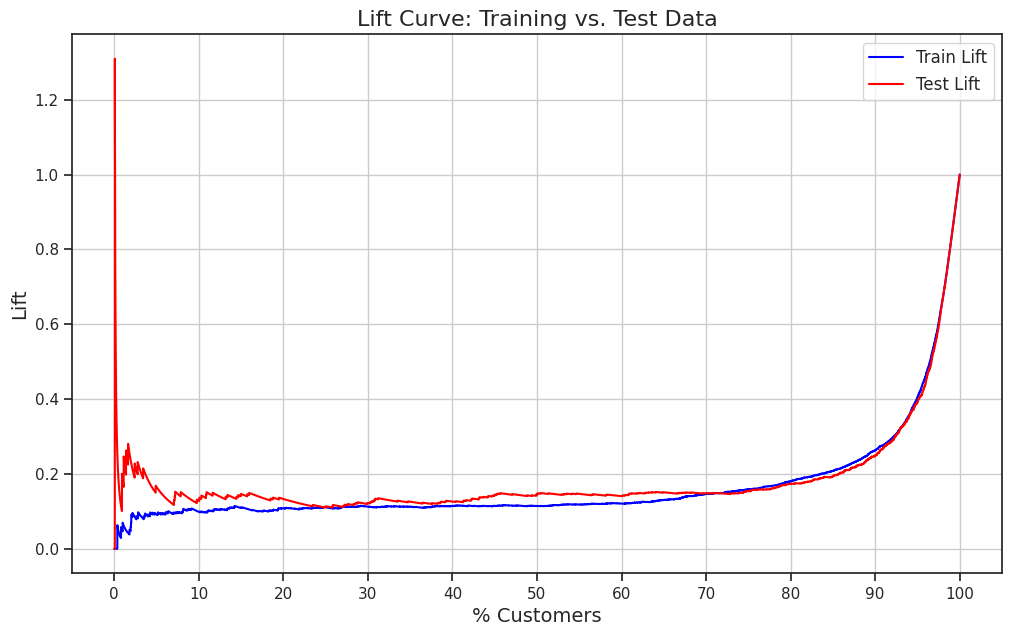

In [124]:
plot_lift_curve_percentage(y1_train,y1_train_pred,y1_,y1_lr,'lift1')

### Precision Recall

In [125]:
def plot_precision_recall(y_train, y_pred_train, y_test, y_pred_test, sample):
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train)
    auc_pr_train = auc(recall_train, precision_train)

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_test)
    auc_pr_test = auc(recall_test, precision_test)
    
    plt.figure(figsize=(10, 7))
    
    train_label = f'Training AUC PR = {auc_pr_train:.2f}'
    test_label = f'Test AUC PR = {auc_pr_test:.2f}'
    plt.plot(recall_train, precision_train, color='blue', label=train_label)
    plt.plot(recall_test, precision_test, color='red', label=test_label)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(title='Legend', loc='lower left')
    plt.grid(True)
    plt.savefig(f'{sample}.png')
    plt.show()

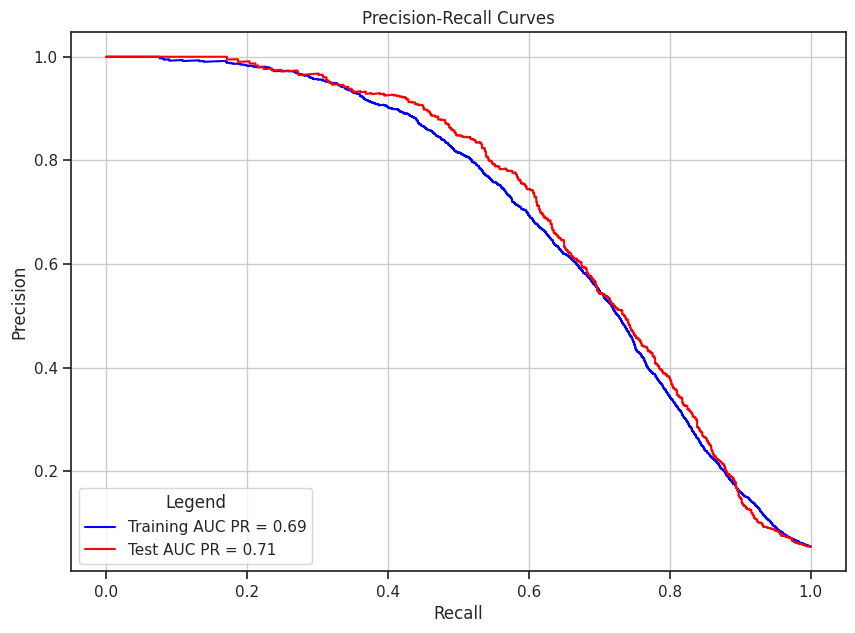

In [126]:
plot_precision_recall(y1_train,y1_train_pred,y1_,y1_lr,'precision_recall1')

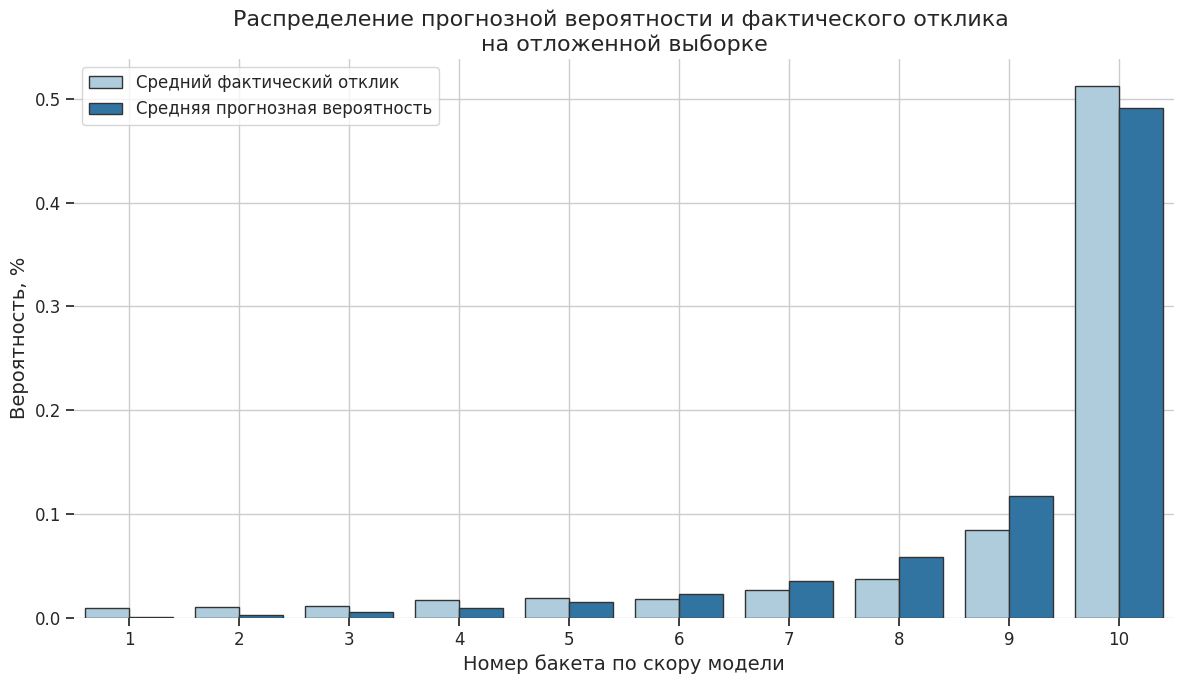

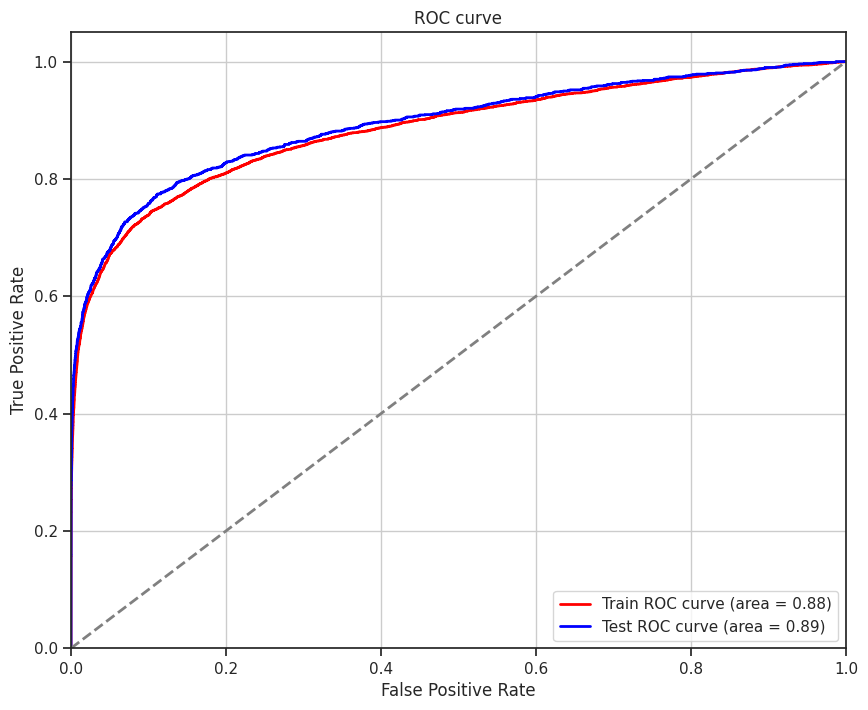

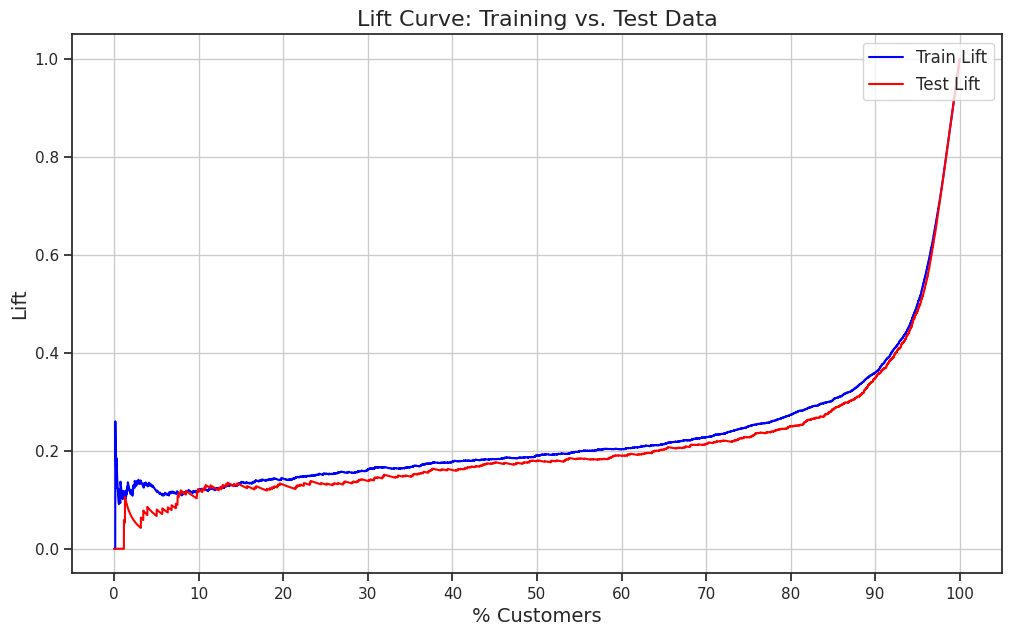

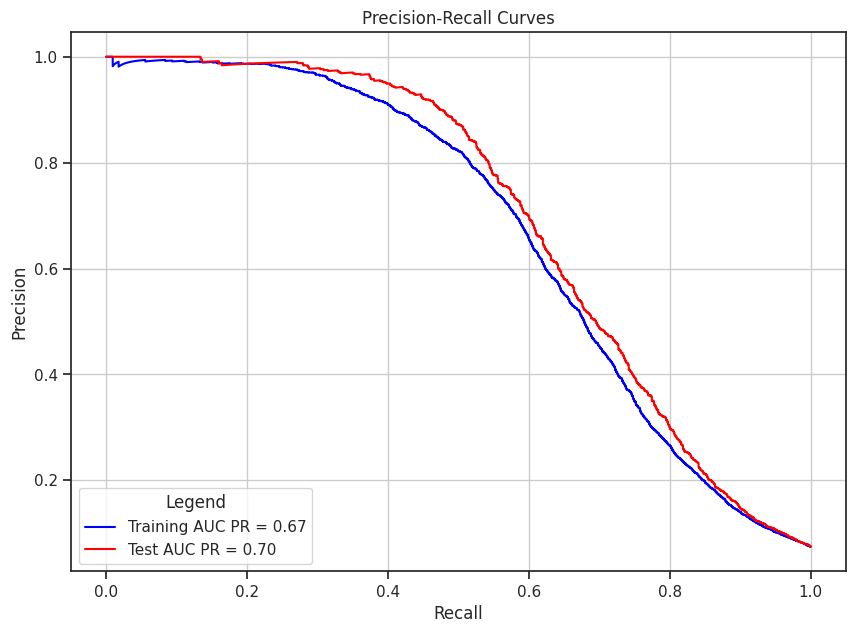

In [127]:
plot_bucket(y2_,y2_lr,'calibration2')
AUC_ROC(y2_train,y2_train_pred,y2_,y2_lr,'AUC_ROC2')
plot_lift_curve_percentage(y2_train,y2_train_pred,y2_,y2_lr,'lift2')
plot_precision_recall(y2_train,y2_train_pred,y2_,y2_lr,'precision_recall2')

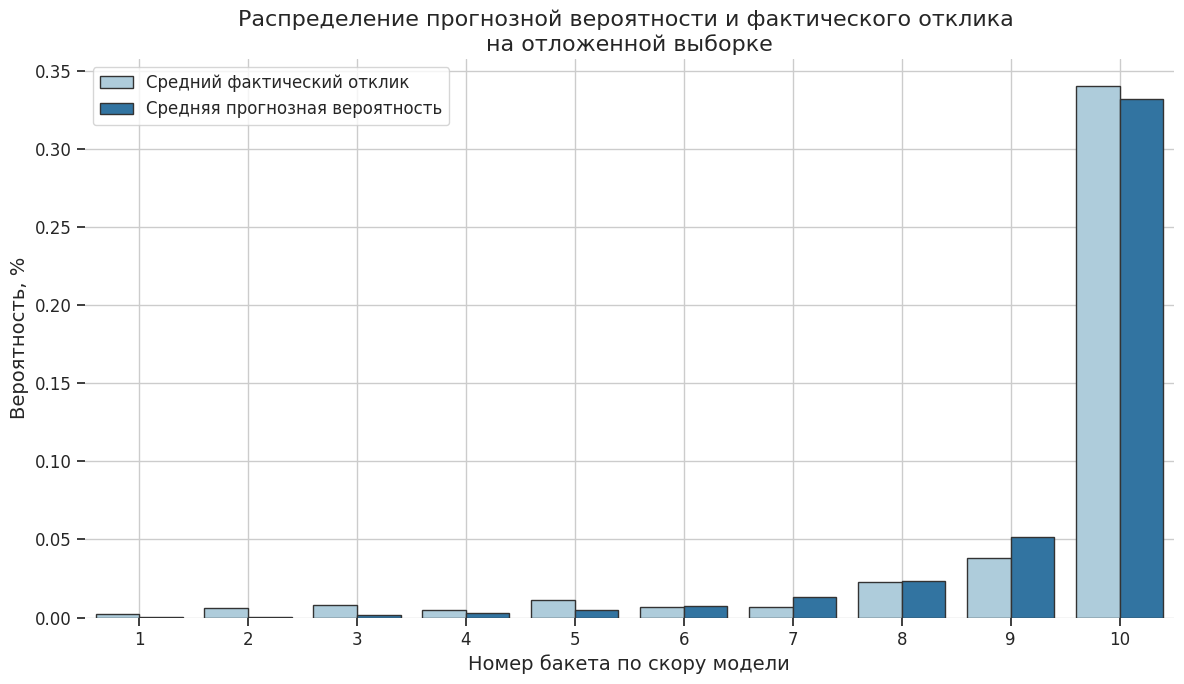

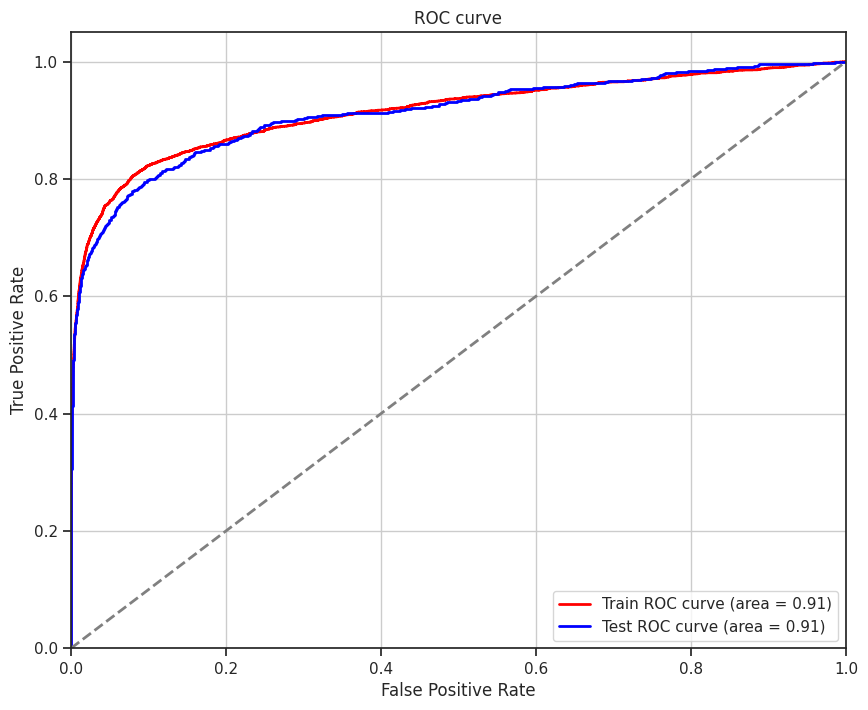

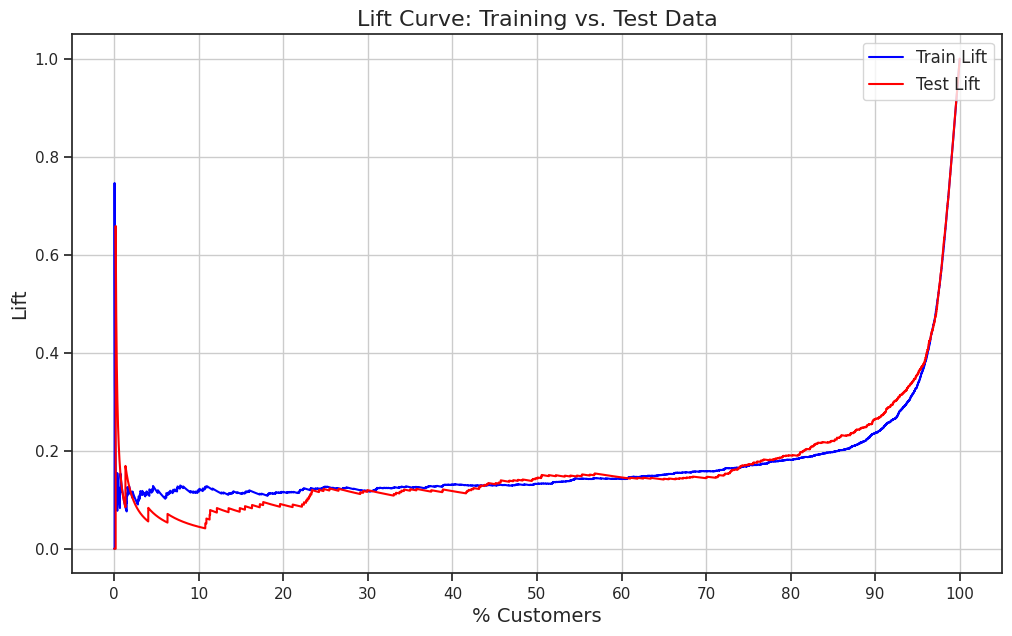

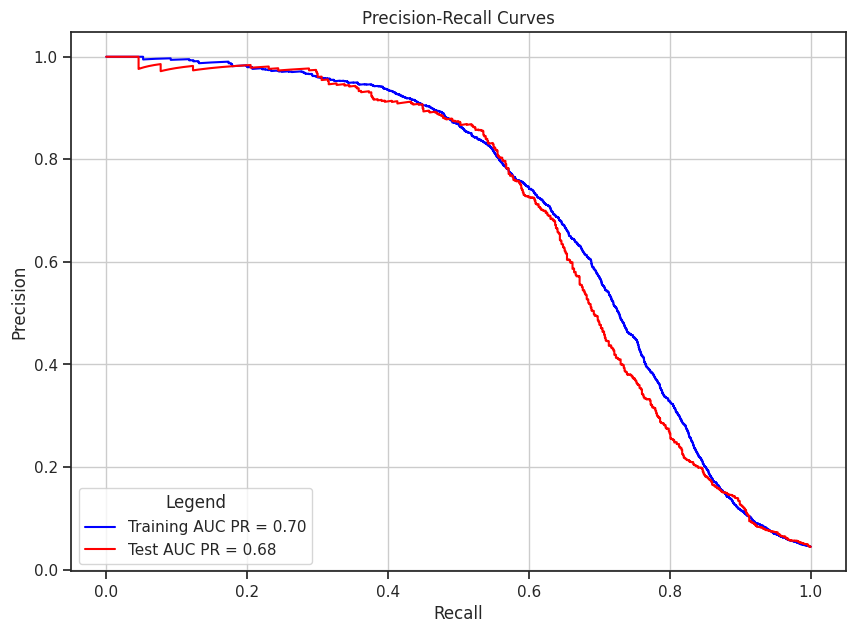

In [128]:
plot_bucket(y3_,y3_lr,'calibration3')
AUC_ROC(y3_train,y3_train_pred,y3_,y3_lr,'AUC_ROC3')
plot_lift_curve_percentage(y3_train,y3_train_pred,y3_,y3_lr,'lift3')
plot_precision_recall(y3_train,y3_train_pred,y3_,y3_lr,'precision_recall3')

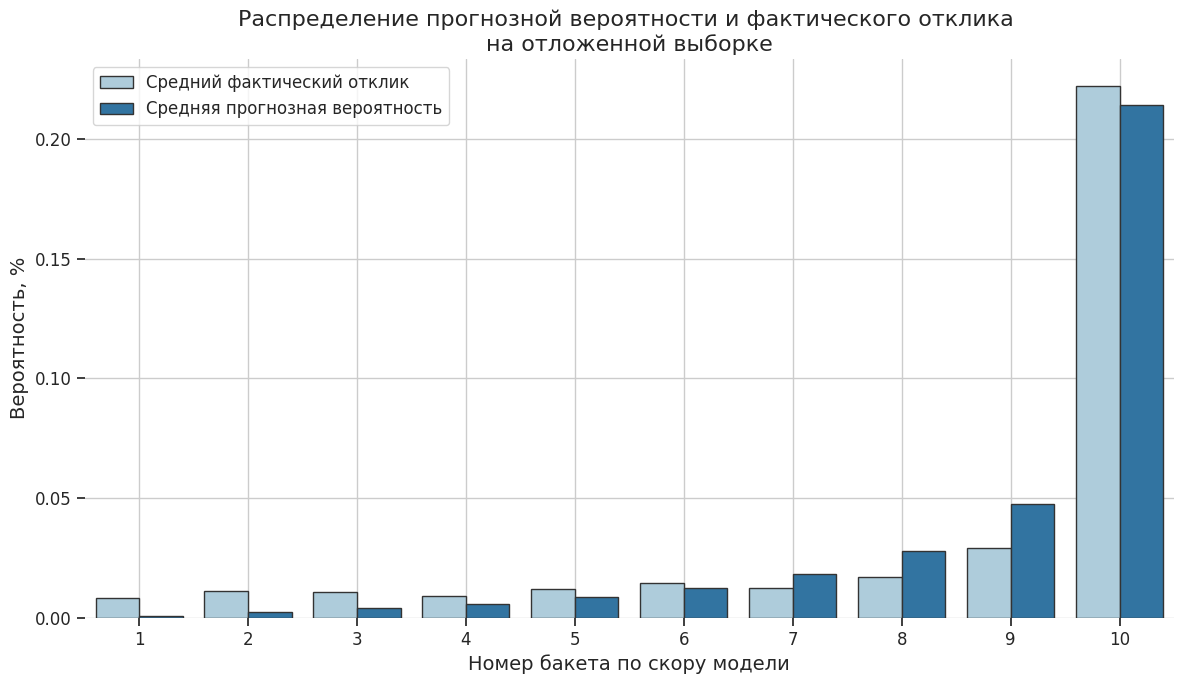

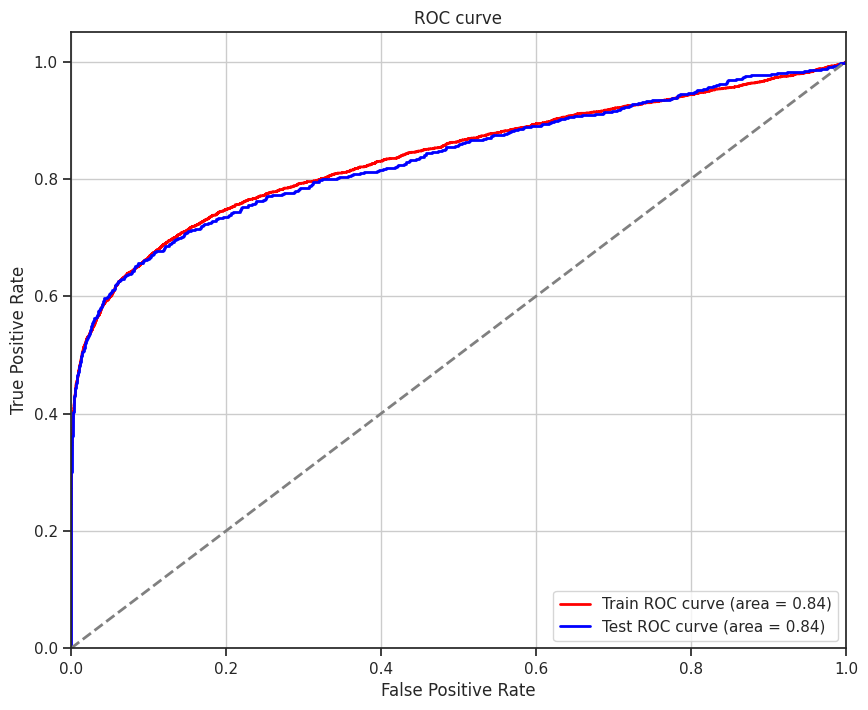

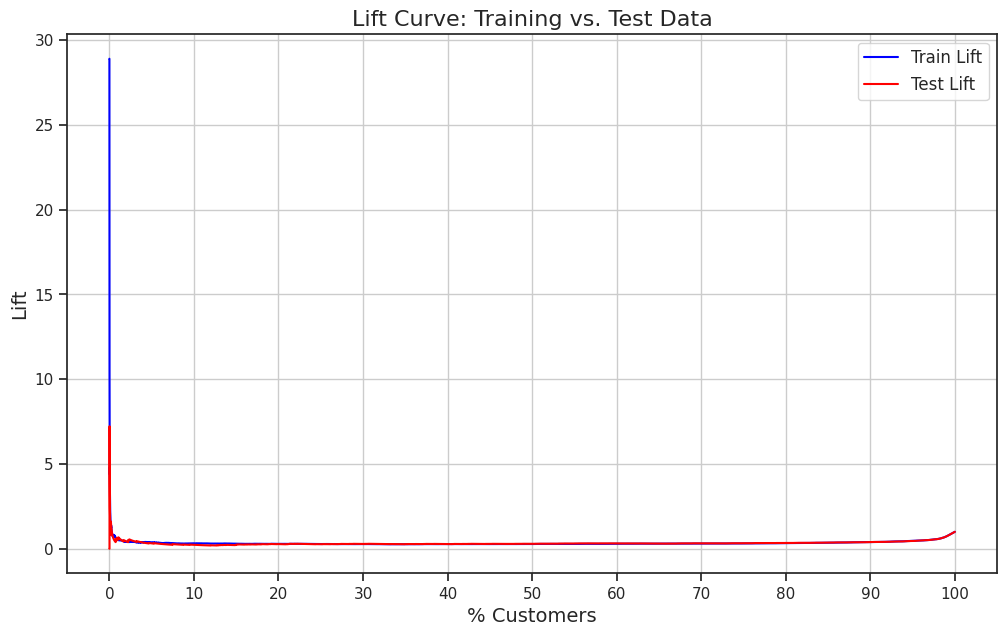

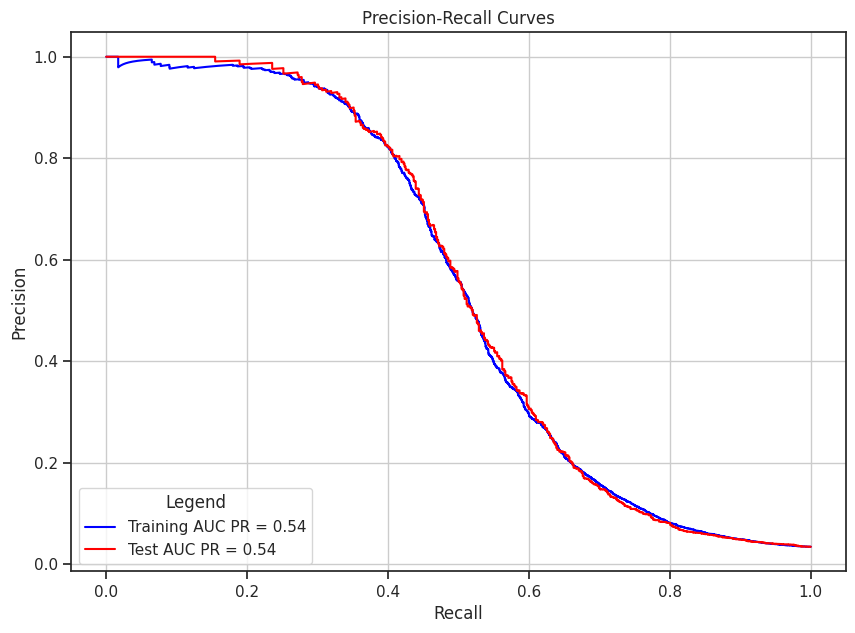

In [129]:
plot_bucket(y4_,y4_lr,'calibration4')
AUC_ROC(y4_train,y4_train_pred,y4_,y4_lr,'AUC_ROC4')
plot_lift_curve_percentage(y4_train,y4_train_pred,y4_,y4_lr,'lift4')
plot_precision_recall(y4_train,y4_train_pred,y4_,y4_lr,'precision_recall4')

In [130]:
def predict_data_metrics(df_test,model):
    X_test = df_test.drop(['target'], axis=1)
    y_pred_prob = model.predict(X_test)
    return y_pred_prob

In [131]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    return metrics

In [132]:
y1_metr = predict_data_metrics(df1_test, lr_model1)
calculate_metrics(y1_,y1_metr)

{'Accuracy': 0.96785,
 'Precision': 0.8533123028391167,
 'Recall': 0.49587534372135655,
 'F1 Score': 0.6272463768115942}

In [133]:
y2_metr = predict_data_metrics(df2_test, lr_model2)
calculate_metrics(y2_,y2_metr)

{'Accuracy': 0.95705,
 'Precision': 0.8963795255930087,
 'Recall': 0.48058902275769744,
 'F1 Score': 0.6257080610021787}

In [134]:
y3_metr = predict_data_metrics(df3_test, lr_model3)
calculate_metrics(y3_,y3_metr)

{'Accuracy': 0.9739,
 'Precision': 0.8793456032719836,
 'Recall': 0.48152295632698766,
 'F1 Score': 0.622286541244573}

In [135]:
y4_metr = predict_data_metrics(df4_test, lr_model4)
calculate_metrics(y4_,y4_metr)

{'Accuracy': 0.97525,
 'Precision': 0.9377777777777778,
 'Recall': 0.30491329479768786,
 'F1 Score': 0.460196292257361}